/home/romuald/ENSEIGNEMENT/1-JupyterNotebooks/pyPhysChem



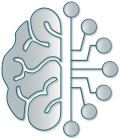

**Start at:** Wednesday 23 July 2025, 21:32:45  
**Hostname:** device-9.home (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

In [14]:
import os
import sys

print(os.getcwd())
cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color
vID.init(cwd0)
import tools4pyPhysChem as t4pPC

__author__ = "romuald.poteau@utoulouse.fr"
__version__ = "20250723"

# Bayesian optimization in chemistry

<div class="intro">

In discovery and process chemistry, one of the main difficulties is identifying the best reaction conditions—such as the catalyst and ligand—while minimizing the number of experiments. This task becomes especially complex when the range of possible conditions is vast and experimental resources (in terms of time or cost) are limited.

Conventional optimization methods can be inefficient and expensive, especially when the initial experiments are far from the optimal solution and system knowledge is limited. In contrast, machine learning techniques like Bayesian optimization are well adapted to this problem: they can efficiently search large reaction spaces while relying on only a small number of data points.

A typical bayesian optimization worflow can be summarized as follows:

<figure>
<img width = "500px" src="MiscImages/Bayes/BayesianOptChemistry.png" alt="Bayesian Optimization in Chemistry" />
<figcaption>Bayesian Optimization of Chemical Reactions <a href="https://blog.3ds.com/brands/biovia/bayesian-optimization-of-chemical-reactions/">(after this blog)</a></figcaption>
</figure> 
</div>

## Introduction to bayesian probabilities

### General Objective

<div class="intro">

**Bayesian probability** provides a framework for modeling uncertainty about unknown quantities by combining:

- what we know *before* observing data (the **prior**);
- what we learn *from* the data (the **likelihood**);
- to obtain what we know *after* seeing the data (the **posterior**).
<br></div>
    
### Bayes’ Theorem

<div class="intro">

The cornerstone of Bayesian inference is **Bayes’ theorem**:

$$
\mathcal{P}(H \mid E) = \frac{\mathcal{P}(E \mid H) \cdot \mathcal{P}(H)}{\mathcal{P}(E)}
$$

where:

- $H$ is the Hypothesis, *i.e.* an unknown parameter (e.g., a rate constant $k$),
- $E$ is the Evidence, *i.e.* an observed data (e.g., concentration measurements),
- $\mathcal{P}(H)$ is the **prior distribution**; it refers to the probability of the hypothesis being true <u>without having observed any evidence</u>,
- $\mathcal{P}(E \mid H)$ is the **likelihood**; it refers to the probability of observing the evidence in the case where the hypothesis is known to be true,
- $\mathcal{P}(H \mid E)$ is the **posterior distribution**; it refers to the probability of the hypothesis being true after having observed the evidence,
- $\mathcal{P}(E)$ is the **marginal likelihood**; it's a normalizing constant that refers to the probability of the evidence occurring independent of any hypothesis.
</div>


### Example: the single die problem

<div class="intro">
    
Imagine that we for some reason are unsure of the probability of rolling a six for a given die. We are actually suspicious that the die is unfair, and thus we hold the prior belief that the probability of rolling a six is 50% (1/2), instead of the typical 16.7% (1/6) for a **fair** die, because the 6 part of the die has been **loaded**.

#### Mapping of the formula

- $\mathcal{P}(H)$ = Prior belief in each hypothesis: e.g. 0.5 for fair, 0.5 for loaded
- $\mathcal{P}(E \mid H)$ = Likelihood, the probability of getting the observed rolls if the die is $H$, *i.e.* fair or loaded 
- $\mathcal{P}(H \mid E)$ = Posterior, the updated belief after observing the data
- $\mathcal{P}(E)$ = Marginal likelihood, the probability of the data under *all* possible hypotheses

Because you don’t know which hypothesis is true, but you do want to compute the overall probability of seeing the evidence (the rolls). That means you must consider all the possible ways the evidence could have occurred, weighted by how likely each hypothesis is. So:

$$\mathcal{P}(E)=\sum_{i}\mathcal{P}(E|H_{i})\mathcal{P}(H_{i})$$

#### Run an example

Let's define $H_1$ = fair die and $H_2$ = loaded die.

Assume:
- $\mathcal{P}(H_1) = 0.5$, $\text{P}(H_2) = 0.5$
- $\mathcal{P}(6 \mid H_1) = 1/6$
- $\mathcal{P}(6 \mid H_2) = 1/2$ (loaded die is biased toward 6)

The posterior to roll a 6 is given by:

$$
\mathcal{P}(H_2 \mid 6) = \frac{\mathcal{P}(6 \mid H_2) \cdot \mathcal{P}(H_2)}{\mathcal{P}(6)}
$$

Let's now compute the denominator $\mathcal{P}(6)$, *i.e.* the marginal likelihood:

$$\mathcal{P}(6) = \mathcal{P}(6 \mid H_1)\mathcal{P}(H_1) + \mathcal{P}(6 \mid H_2)\mathcal{P}(H_2)$$

$\mathcal{P}(6) = \frac{1}{6} \cdot 0.5 + \frac{1}{2} \cdot 0.5 = \frac{1}{12} + \frac{1}{4} = \frac{4}{12} = \frac{1}{3}$

After one roll of 6, your belief in the die being loaded goes from 50% to $(0.5 \times 0.5) / (1/3)$, *i.e.* 75%. That’s Bayesian updating.
</div>
<br>
<div class="intro">
    
Let's write a python coding for this case, just to become familiar with the variables and these ideas
</div>

In [ ]:
# Define hypotheses
hypotheses = ['fair', 'loaded']

# Define priors
priors = {
    'fair': 0.5,
    'loaded': 0.5
}

# Define likelihoods
def likelihood(roll, hypothesis):
    if hypothesis == 'fair':
        return 1/6
    elif hypothesis == 'loaded':
        return 0.5 if roll == 6 else 0.5 / 5

# Define observed evidence
observed_roll = 6

# Compute numerator for each hypothesis
numerators = {}
for h in hypotheses:
    numerators[h] = likelihood(observed_roll, h) * priors[h]

# Compute marginal likelihood (normalizing constant)
P_E = sum(numerators.values())

# Compute posterior for each hypothesis
posteriors = {h: numerators[h] / P_E for h in hypotheses}

# Print results
print("Posterior probabilities after observing roll = 6:")
for h in hypotheses:
    print(f"P({h} | 6) = {posteriors[h]:.3f}")


#### Sequential Bayesian Updating

<div class="introT" title="Generate simulated data for a loaded die">

Here’s how to do that in Python:
</div>

In [ ]:
import numpy as np

# Loaded die probabilities
faces = [1, 2, 3, 4, 5, 6]
probs_loaded = [0.1, 0.1, 0.1, 0.1, 0.1, 0.5]

# Simulate 50 rolls from a loaded die
np.random.seed(42)  # for reproducibility
simulated_rolls = list(np.random.choice(faces, size=50, p=probs_loaded))

print(simulated_rolls)


<div class="introT" title="">
    
Let's now simulate Bayesian updating over these rolls, step by step.

We'll:
- Track the posterior after each roll.
- Display the evolving belief that the die is loaded.
- Plot the result.

</div>

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Define hypotheses and priors
hypotheses = ['fair', 'loaded6']
priors = {'fair': 0.5, 'loaded6': 0.5}

# Step 2: Define likelihood function
def likelihood(roll, hypothesis):
    if hypothesis == 'fair':
        return 1/6
    elif hypothesis == 'loaded6':
        return 0.5 if roll == 6 else 0.5 / 5

# Step 3: Function to update priors after a single observation
def update(prior, roll):
    numerators = {h: likelihood(roll, h) * prior[h] for h in hypotheses}
    P_E = sum(numerators.values())
    posterior = {h: numerators[h] / P_E for h in hypotheses}
    return posterior

# Step 4: Run sequential updating
posteriors = [priors]
current = priors.copy()
print(f"  0.         ; current = {{ {', '.join(f'{k}: {v:.2f}' for k, v in current.items())} }}")

for i, roll in enumerate(simulated_rolls):
    current = update(current, roll)
    print(f"{i+1:3d}. Roll = {roll}; current = {{ {', '.join(f'{k}: {v:.2f}' for k, v in current.items())} }}")
    posteriors.append(current)

# Step 5: Extract sequences for plotting
p_fair = [p['fair'] for p in posteriors]
p_loaded = [p['loaded6'] for p in posteriors]

# Step 7: Plot
plt.plot(p_fair, marker='o',label="P(fair | data)")
plt.plot(p_loaded, marker='d',label="P(loaded toward 6| data)")
plt.xlabel("Number of rolls")
plt.ylabel("Posterior probability")
plt.title("Bayesian updating after each die roll")
plt.legend()
plt.grid(True)
plt.show()


<div class="rq">

The data supports the loaded die hypothesis, Bayesian updating accumulates evidence over time and allows you to converge toward the correct hypothesis. The Bayesian model learns that after just a few rolls.
</div>

<div class="app">

You just bought a new die. According to the manufacturer's notice, the die is loaded to favor rolling a 1, with a claimed probability of 50%.
In reality, however, the manufacturer made a mistake: the die is loaded on another number.
Use Bayesian reasoning to check this by computing:

- $\mathcal{P}(\text{fair},\ \text{data})$
- $\mathcal{P}(\text{loaded-toward-1},\ \text{data})$

Where data is this sequence of observed rolls: `[4, 6, 6, 6, 2, 2, 1, 6, 6, 6, 1, 6, 6, 3, 2, 2, 4, 6, 5, 3, 6, 2, 3, 4, 5, 6, 2, 6, 6, 1, 6, 2, 1, 6, 6, 6, 4, 1, 6, 5, 2, 5, 1, 6, 3, 6, 4, 6, 6, 2]`.

What can you conclude?
</div>

In [ ]:
# insert your code here



<div class="sol">

Want to see a possible answer? Uncomment the `# %load ./SolutionsToExercises/...` command below and then run the content of the cell

</div>

In [ ]:
# %load ./SolutionsToExercises/Bayes/loaded_die.py

<div class='rqT' title="Bayesian insight from this application to an incorrectly assumed loaded-toward-1 die">

In this exercise, two hypotheses are compared based on observed data:

- **H0**: The die is loaded to favor rolling a **1**. This hypothesis fails completely to explain the data, since the die is actually biased toward **6** with a probability of 50%.  
- **H1**: The die is fair. This hypothesis fits the data *slightly better*, even though it is also incorrect.

This leads to a fundamental lesson in Bayesian inference:

> **If the truth is not among the proposed hypotheses, the model will choose the one that is least wrong.**

Even though the "fair die" hypothesis is false, it is *less inconsistent* with the data than the "loaded toward 1" hypothesis - and therefore it receives almost all the posterior probability.

</div>

## How to implement a bayesian optimization from scratch in Python

<div class="intro">

after this [Bayesian Optimization algorithm](https://machinelearningmastery.com/what-is-bayesian-optimization/)
</div>

## Prerequisites (Appendix)

### Normal distribution

<div class="intro">
A random variable $X$ follows a **normal distribution** with mean $\mu$ and variance $\sigma^2$ if:

$$
X \sim \mathcal{N}(\mu, \sigma^2)
$$

The probability density function (PDF) is given by:

$$
f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)
$$

- $\mu$ is the **mean** (center of the distribution)
- $\sigma$ is the **standard deviation** (spread)

A normal distribution is symmetric around its mean, and approximately:
- 68% of the data falls within $\mu \pm \sigma$
- 95% within $\mu \pm 2\sigma$
</div>

#### Standard Normal Distribution: $\mathcal{N}(0, 1)$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Standard normal parameters
x = np.linspace(-4, 4, 1000)
mu = 0
sigma = 1

def gaussian(x,mu,sigma):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

y = gaussian(x,mu,sigma)
plt.figure(figsize=(8, 5))
plt.plot(x, y, label=r"$\mathcal{N}(0, 1)$", color='blue')
plt.fill_between(x, y, where=(x > mu - sigma) & (x < mu + sigma), color='blue', alpha=0.2, label="~68% within ±1σ")
plt.fill_between(x, y, where=(x > mu - 2*sigma) & (x < mu + 2*sigma), color='blue', alpha=0.1, label="~95% within ±2σ")
plt.title("Standard Normal Distribution", fontsize=16)
plt.xlabel("x", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

#### Non-Standard Normal Distribution: $\mathcal{N}(0.5, 0.7^2)$

<div class='intro'>

When we talk about a non-standard normal distribution, it simply means that it is not centered at 0 and/or does not have a standard deviation of 1.
</div>

In [ ]:
# Non-standard normal parameters
x = np.linspace(-2, 3, 1000)
mu = 0.5
sigma = 0.7
y = gaussian(x,mu,sigma)

plt.figure(figsize=(8, 5))
plt.plot(x, y, label=r"$\mathcal{N}(0.5, 0.7^2)$", color='darkorange')
plt.fill_between(x, y, where=(x > mu - sigma) & (x < mu + sigma), color='orange', alpha=0.3, label="~68% within ±1σ")
plt.fill_between(x, y, where=(x > mu - 2*sigma) & (x < mu + 2*sigma), color='orange', alpha=0.15, label="~95% within ±2σ")
plt.title("Non-Standard Normal Distribution", fontsize=16)
plt.xlabel("x", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

<div class="intro">

Any normal distribution $\mathcal{N}(\mu, \sigma^2)$ can be transformed into a standard normal distribution via the change of variable:

$$
Z = \frac{X - \mu}{\sigma}
$$

Let’s simulate 1000 values from $X \sim \mathcal{N}(2, 3^2)$, then standardize them to get $Z \sim \mathcal{N}(0,1)$
</div>

In [ ]:
# Original distribution parameters
mu = 2
sigma = 3

# Define the original and standardized x ranges
x_original = np.linspace(-7, 11, 1000)
x_standardized = (x_original - mu) / sigma  # Standardized x values

# Evaluate densities
y_original = gaussian(x_original, mu, sigma)
y_standardized = gaussian(x_standardized, 0, 1)

# Plot both
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_original, y_original, color='darkorange')
plt.title(f"Original Distribution: $\\mathcal{{N}}$({mu}, {sigma}$^2$)")
plt.xlabel("x")
plt.ylabel("Density")

plt.subplot(1, 2, 2)
plt.plot(x_standardized, y_standardized, color='blue')
plt.title("Standardized Distribution: $\\mathcal{N}(0, 1)$")
plt.xlabel("z = (x - 0.5) / 0.5")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

<div class="rqT", title="Origin of 68% and 95%">

If a random variable $X$ follows a normal distribution $\mathcal{N}(\mu, \sigma^2)$, then:
- 68% of the values lie within the interval: $[μ−σ, μ+σ]$
- 95% of the values lie within: $[μ−2σ, μ+2σ]$
- 99.7% of the values lie within: $[μ−3σ, μ+3σ]$
</div>

In [ ]:
# Static plot and integral calculation for the empirical rule (68–95–99.7)

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Plot standard normal distribution
x = np.linspace(-4, 4, 1000)
y = gaussian(x,0,1)

# Define sigma values to test
sigma_values = [0.7, 1, 2, 3]
areas = []

# Compute areas under the standard normal curve
for k in sigma_values:
    area, abserr = quad(gaussian, -k, k, args=(0,1))
    areas.append(area)

print(areas, abserr)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Standard Normal PDF", color='black')

colors = ['orange', 'blue', 'green', 'red']

for k, area, color, label in zip(sigma_values, areas, colors, labels):
    x_fill = np.linspace(-k, k, 500)
    y_fill = gaussian(x_fill,0,1)
    plt.fill_between(x_fill, y_fill, alpha=0.2, color=color, label=f"±{k}σ: {100*area:.1f}%")

plt.title("Areas under $\\mathcal{N}(0,1)$")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


# End 

In [ ]:
vID.end(cwd0)